# HW4. Indexes & Query Processing & Normalization

## Objectives

In this assignment, you will review what you have learned in the Transaction Processing, Normalization, Views and Indexes, and Query Processing Modules. In particular, you will practice:

- How to decide if a transaction schedule is conflict-serializable
- How indexing can change query processing
- How indexing changes query performance
- How B-Trees store records
- Query processing and optimization
- How to construct BCNF and 3NF decomposition

## Q1 (10 points): Transaction Processing

Consider this schedule: $r1(A); r2(A); r1(B); r2(B); r3(A); r4(B); w1(A); w2(B);$

Q1.1 (5 points) What is the precedence graph for the schedule?

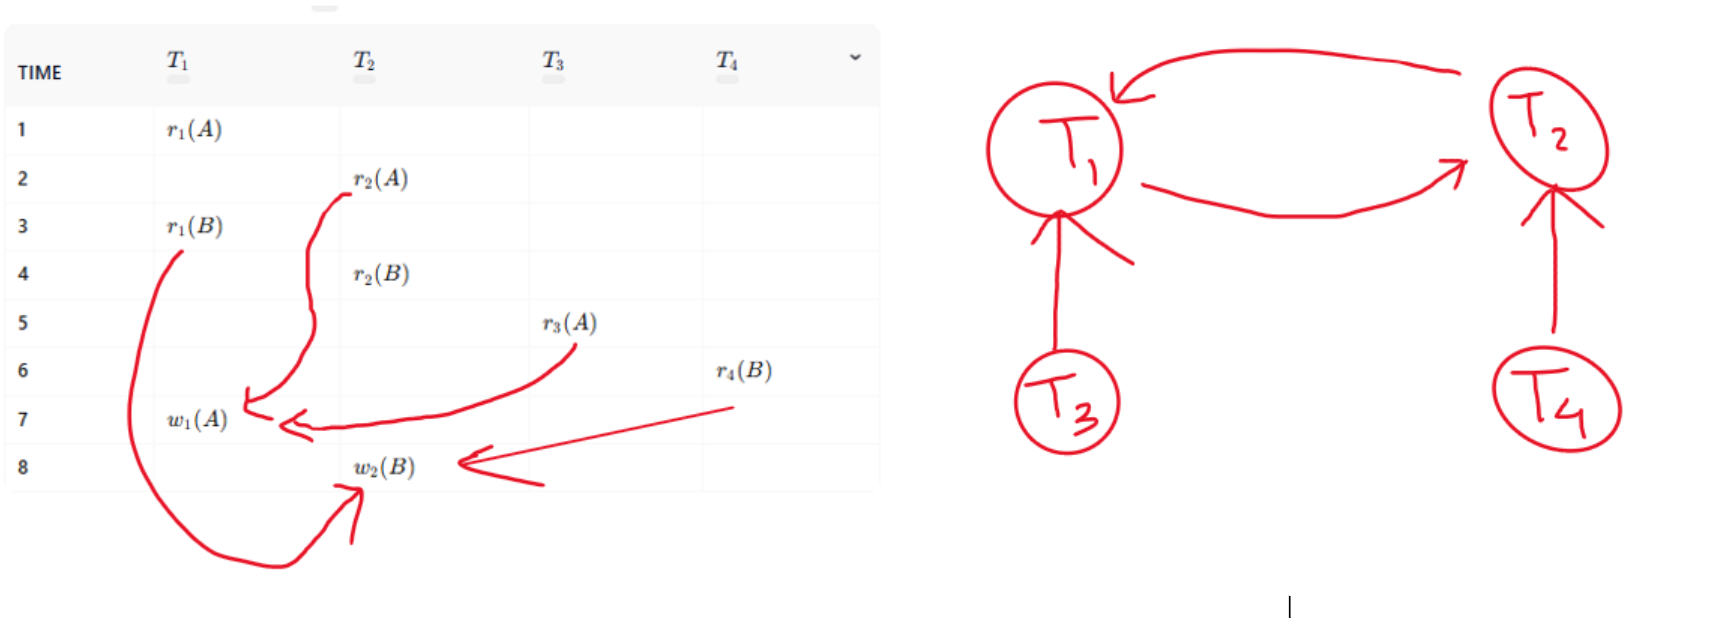

#PROVIDE YOUR ANSWER HERE. 

##You may provide an image containing your answers for this question. 

##See https://mljar.com/blog/jupyter-notebook-insert-image/ for ways to insert images in Jupyter Notebook.

Q1.2 (5 points) Is the schedule confict-serializable? If so, what are all the equivalent
serial schedules?

The schedule is NOT conflict-serializable because the precedence graph contains a cycle:  
T₁ → T₂ → T₁  
When a precedence graph contains a cycle, it means the schedule cannot be transformed into a serial schedule while preserving all the conflicts. Therefore, there are no equivalent serial schedules.

## Q2 (10 points): Indexing

In this question, you will be asked to select suitable indexes to speed up query performance and examine the query plan of a SQL query.

We are going to use a new database called flights.db. In the database, there is a single table, called FLIGHTS. The following shows its schema:

    FLIGHTS(fid, year, month_id, day_of_month, day_of_week_id, 
            carrier_id, flight_num, origin_city, origin_state, 
            dest_city, dest_state, departure_delay, taxi_out, 
            arrival_delay, canceled, actual_time, distance)

Note that this task only needs to use four attributes: `carrier_id`, `origin_city`, `actual_time`, and `dest_city`.

In [1]:
%load_ext sql

In [2]:
%sql sqlite:///flight.db

Consider the following queries:

```sqlite
(a)  SELECT DISTINCT carrier_id
     FROM Flights
     WHERE origin_city = 'Seattle WA' AND actual_time <= 180;
```


```sqlite
(b)  SELECT DISTINCT carrier_id
     FROM Flights
     WHERE origin_city = 'Gunnison CO' AND actual_time <= 180;
```


```sqlite
(c)  SELECT DISTINCT carrier_id
     FROM Flights
     WHERE origin_city = 'Seattle WA' AND actual_time <= 30;
```

Choose one single simple index (index on one attribute) that is most likely to speed up all three queries. Write down the `CREATE INDEX` statement and explain why you chose that index below.

Q2.1. (1 point) What is the CREATE INDEX statement?

In [4]:
%%sql
CREATE INDEX idx_origin_city ON FLIGHTS(origin_city);

 * sqlite:///flight.db
Done.


[]

Q2.2. (1 point) Why did you choose the index? 

The index on origin_city optimizes the equality conditions in all three queries, reducing the rows scanned.  
##CHECK  
I chose to index on origin_city because all three queries (a, b, c) have a filter condition on origin_city with equality comparison. This will allow the database to quickly locate the records for specific cities without scanning the entire table. Since the queries are looking for distinct carrier_ids from specific origin cities with time constraints, indexing origin_city would significantly speed up the initial filtering.

Open a command line shell and start the sqlite program. Connect to the provided flights.db, and check whether the FLIGHTS table has the index that you indicate above. If not, add this index to the FLIGHTS table. 

Q2.3. (0.5 point) Does the FLIGHTS table has the index that you indicate above?  Justify your answer with command line shell outputs.

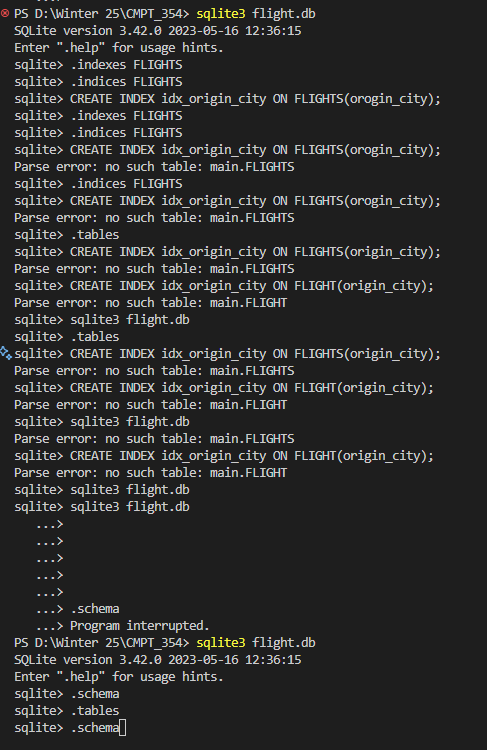

In [6]:
%%sql
.indices FLIGHTS

 * sqlite:///flight.db
(sqlite3.OperationalError) near ".": syntax error
[SQL: .indices FLIGHTS]
(Background on this error at: https://sqlalche.me/e/20/e3q8)


Q2.4. (1.5 point) Please check whether each query used the index or not.  Justify your answer with command line shell outputs.

**Hint:** you can use `EXPLAIN QUERY PLAN` to see the query plan of each query. Indicate for each query if it used the index or not. 

##REPLACE WITH YOUR ANSWER

In [10]:
%%sql
EXPLAIN QUERY PLAN 
SELECT DISTINCT carrier_id 
FROM Flights 
WHERE origin_city = 'Seattle WA' AND actual_time <= 180;

EXPLAIN QUERY PLAN 
SELECT DISTINCT carrier_id 
FROM Flights 
WHERE origin_city = 'Gunnison CO' AND actual_time <= 180;

EXPLAIN QUERY PLAN 
SELECT DISTINCT carrier_id 
FROM Flights 
WHERE origin_city = 'Seattle WA' AND actual_time <= 30;

 * sqlite:///flight.db
Done.
Done.
Done.


id,parent,notused,detail
4,0,0,SEARCH Flights USING INDEX idx_origin_city (origin_city=?)
18,0,0,USE TEMP B-TREE FOR DISTINCT


Now, consider this query:

```sqlite
(d) SELECT DISTINCT F2.origin_city
     FROM Flights F1, Flights F2
     WHERE F1.dest_city = F2.dest_city
         AND F1.origin_city='Gunnison CO'
         AND F1.actual_time <= 30;
```

Q2.5. (2 points) Choose one simple index (index on one attribute), different from the index for the question above, that is likely to speed up this query. Write down the `CREATE INDEX` statement.

In [8]:
%%sql
CREATE INDEX idx_dest ON Flights(dest_city);

 * sqlite:///flight.db
Done.


[]

Check whether the FLIGHTS table has this second index that you indicate above. If not, add this index to the FLIGHTS table. 

Now we want to know how effective the two indexes are. We compare the runtimes of the queries with and without indexes. 

**Hint:** Use `timer on` on sqlite3 command line to turn SQL timer on.

Q2.6. (2 points) Execute queries (a) to (d) on the FLIGHTS table that do not have the two indexes. Please record the runtime of each query. 

In [ ]:
%%sql

DROP INDEX IF EXISTS idx_origin_city;
DROP INDEX IF EXISTS idx_dest_city;

-- Turn on the timer fo the sqlite3 shell
.timer on


-- a
SELECT DISTINCT carrier_id 
FROM Flights 
WHERE origin_city = 'Seattle WA' AND actual_time <= 180;

-- b
SELECT DISTINCT carrier_id 
FROM Flights 
WHERE origin_city = 'Gunnison CO' AND actual_time <= 180;

-- c
SELECT DISTINCT carrier_id 
FROM Flights 
WHERE origin_city = 'Seattle WA' AND actual_time <= 30;

-- d
SELECT DISTINCT F2.origin_city
FROM Flights F1, Flights F2
WHERE F1.dest_city = F2.dest_city
  AND F1.origin_city='Gunnison CO'
  AND F1.actual_time <= 30;

 * sqlite:///flight.db
Done.
Done.
(sqlite3.OperationalError) near ".": syntax error
[SQL: .timer on


SELECT DISTINCT carrier_id 
FROM Flights 
WHERE origin_city = 'Seattle WA' AND actual_time <= 180;]
(Background on this error at: https://sqlalche.me/e/20/e3q8)


Q2.7. (2 points) Execute queries (a) to (d) on the FLIGHTS table that has the two indexes. Please record the runtime of each query. 

In [14]:
%%sql
CREATE INDEX idx_origin_city ON Flights(origin_city);
CREATE INDEX idx_dest_city ON Flights(dest_city);

-- Turn on the timer fo the sqlite3 shell
.timer on

-- a
SELECT DISTINCT carrier_id 
FROM Flights 
WHERE origin_city = 'Seattle WA' AND actual_time <= 180;

-- b
SELECT DISTINCT carrier_id 
FROM Flights 
WHERE origin_city = 'Gunnison CO' AND actual_time <= 180;

-- c
SELECT DISTINCT carrier_id 
FROM Flights 
WHERE origin_city = 'Seattle WA' AND actual_time <= 30;

-- d
SELECT DISTINCT F2.origin_city
FROM Flights F1, Flights F2
WHERE F1.dest_city = F2.dest_city
  AND F1.origin_city='Gunnison CO'
  AND F1.actual_time <= 30;

 * sqlite:///flight.db
Done.
Done.
(sqlite3.OperationalError) near ".": syntax error
[SQL: -- Turn on the timer fo the sqlite3 shell
.timer on

-- a
SELECT DISTINCT carrier_id 
FROM Flights 
WHERE origin_city = 'Seattle WA' AND actual_time <= 180;]
(Background on this error at: https://sqlalche.me/e/20/e3q8)


## Q3 (6 points): B-Trees

Assume:

    (1) blocks can hold either 10 records or 99 keys and 100 pointers
    (2) the average B-tree node is 70% full. This means it will have 69 keys and 70 pointers. 

We can use B-trees as part of several different structures. For each structure described in the questions Q2.1 to Q2.3 below, determine: 

    (a) the total number of blocks needed for a 1,000,000-record file
    (b) the average number of disk I/O’s to retrieve a record given its search key

You may assume nothing is in memory initially, and the search key is the primary key for the records.

Q3.1. (2 points) The data file is a sequential file, sorted on the search key, with 10 records per block. The B-tree is a dense index.

Dense B-tree is a dense index. Also with sorted data file. so `Dense Index on Sorted Data`  
(a) Total number of blocks needed:
- Data file: 1,000,000 records ÷ 10 records per block = 100,000 blocks
- Dense index: 1,000,000 keys
  - Number of leaf nodes: 1,000,000 keys ÷ 69 keys per node (70% full) = 14,493 nodes
  - Height of the tree:
    - Level 1 (leaves): 14,493 nodes
    - Level 2: 14,493 ÷ 70 = 208 nodes
    - Level 3: 208 ÷ 70 = 3 nodes
    - Level 4 (root): 1 node
  - Total index blocks: 14,493 + 208 + 3 + 1 = 14,705 blocks

Total blocks: 100,000 (data) + 14,705 (index) = `114,705 blocks`  

(b) Average disk I/Os to retrieve a record:
- Find leaf node: 4 I/Os (height of the tree)
- Access data block: 1 I/O  
Total: `5 I/Os`



Q3.2. (2 points) The data file is a sequential file, sorted on the search key, with 10 records per block. The B-tree is a sparse index.

This one is `Sparse Index on Sorted Data`  
(a) Total number of blocks needed:
- Data file: 100,000 blocks (same as above)
- Sparse index: 1 key per data block = 100,000 keys
  - Number of leaf nodes: 100,000 keys ÷ 69 keys per node = 1,450 nodes
  - Height of the tree:
    - Level 1 (leaves): 1,450 nodes
    - Level 2: 1,450 ÷ 70 = 21 nodes
    - Level 3 (root): 1 node
  - Total index blocks: 1,450 + 21 + 1 = 1,472 blocks

Total blocks: 100,000 (data) + 1,472 (index) = `101,472 blocks`

(b) Average disk I/Os to retrieve a record:
- Find leaf node: 3 I/Os (height of the tree)
- Access data block: 1 I/O  
Total: `4 I/Os`


Q3.3. (2 points) The data file consists of records in no particular order, packed 10 to a block. The B-tree is a dense index.

This one is `Dense Index on Unsorted Data`  
(a) Total number of blocks needed:
- Data file: 100,000 blocks (same as above)
- Dense index: 1,000,000 keys (same as Q3.1)
  - Total index blocks: 14,705 (same as Q3.1)

Total blocks: 100,000 (data) + 14,705 (index) = `114,705 blocks`

(b) Average disk I/Os to retrieve a record:
- Find leaf node: 4 I/Os (height of the tree)
- Access data block: 1 I/O  
Total: `5 I/Os`



## Q4 (6 points + 3 bonus points): Query Processing

In the first assignment, given the bank database below:

 - Customer = {<span style="text-decoration:underline">customerID</span>, firstName, lastName, income, birthDate}
 - Account = {<span style="text-decoration:underline">accNumber</span>, type, balance, branchNumber<sup>FK-Branch</sup>}
 - Owns = {<span style="text-decoration:underline">customerID</span><sup>FK-Customer</sup>, <span style="text-decoration:underline">accNumber</span><sup>FK-Account</sup>}
 - Transactions = {<span style="text-decoration:underline">transNumber</span>, <span style="text-decoration:underline">accNumber</span><sup>FK-Account</sup>, amount}
 - Employee = {<span style="text-decoration:underline">sin</span>, firstName, lastName, salary, branchNumber<sup>FK-Branch</sup>}
 - Branch = {<span style="text-decoration:underline">branchNumber</span>, branchName, managerSIN<sup>FK-Employee</sup>, budget}

you wrote a SQL query to:

Show account number, account type, account balance, and transaction amount of the accounts with balance higher than 100,000 and transaction amounts higher than 15000, starting with the accounts with the highest transaction amount and highest account balance. 

Q4.1. (3 points) Parse your query into a query parse tree.

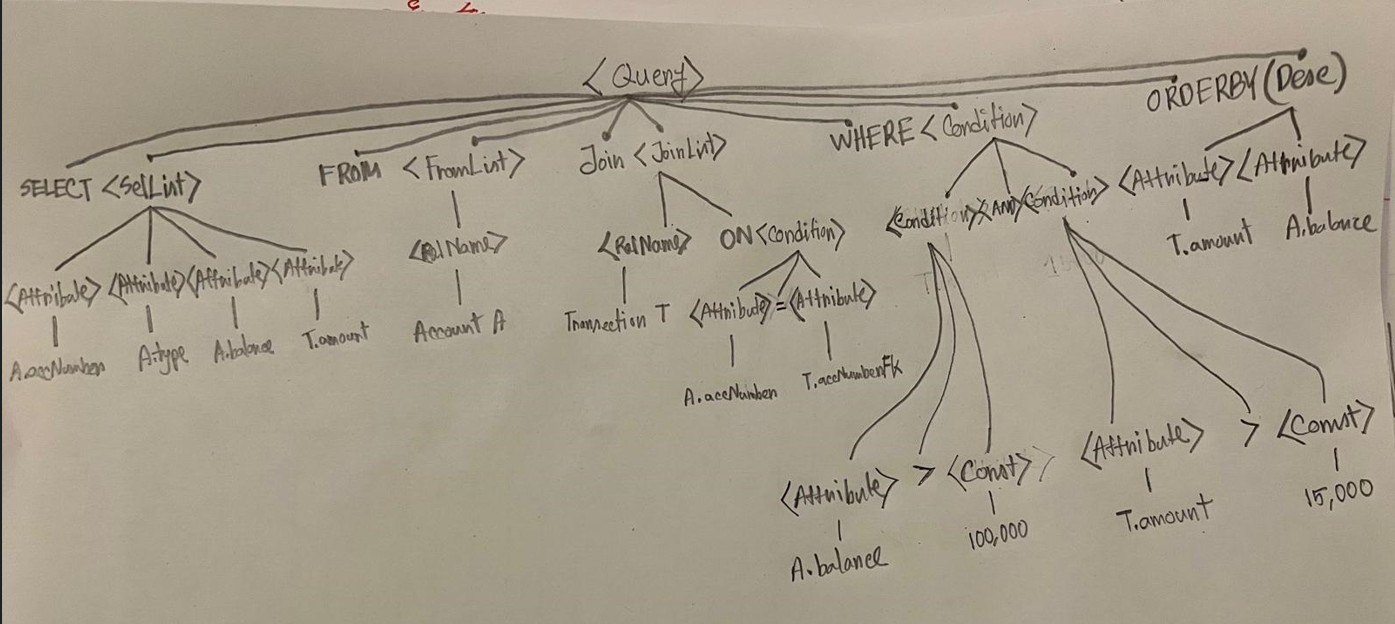

##You may provide an image containing your answers for this question. 

##See https://mljar.com/blog/jupyter-notebook-insert-image/ for ways to insert images in Jupyter Notebook.

Q4.2. (3 points) Convert your parse tree to the equivalent relational algebraic representation (rewrite if necessary).

$
\pi_{\text{A.accNumber}, \text{A.type}, \text{A.balance}, \text{T.amount}} \left( \sigma_{\text{A.balance} > 100000 \land \text{T.amount} > 15000} \left( \text{Account} \, \bowtie_{\text{A.accNumber} = \text{T.accNumberFK}} \text{Transactions} \right) \right) \, \left[ \text{ORDER BY } \text{T.amount DESC}, \text{A.balance DESC} \right]
$




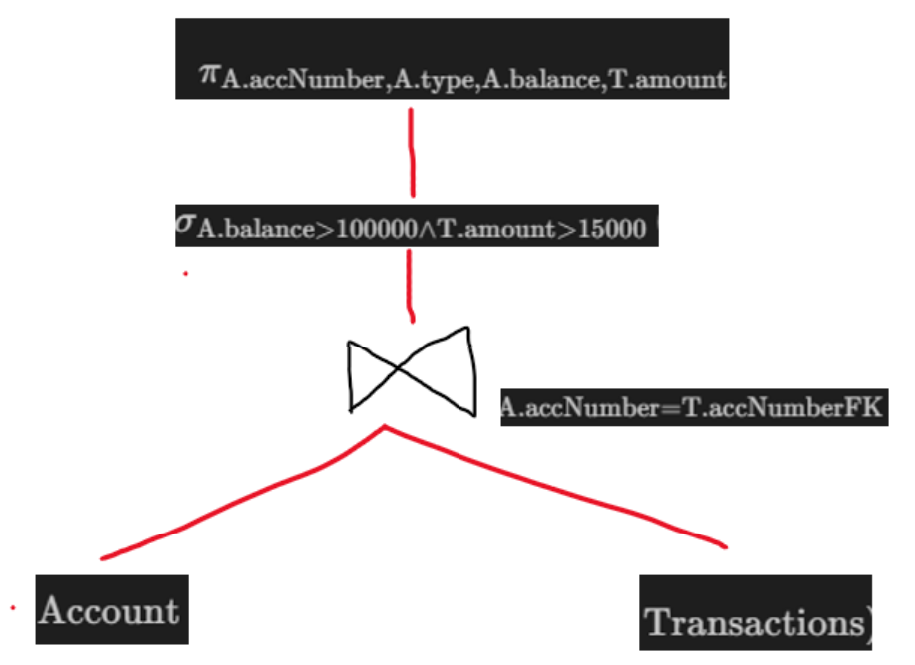

#PROVIDE YOUR ANSWER HERE. 

##You may provide an image containing your answers for this question 

Q4.3. OPTIONAL (bonus 3 points) Assume you have a million records in each of the six tables above. If you need, make necessary assumptions about your storage blocks, as well as about charactristics in the bank.db. Can you estimate the size and cost of the intermediate tables in your query plan?

##PROVIDE YOUR ANSWER HERE.

## Q5 (10 points) Normalization

Consider the schema over attributes A, B, C, D, E, F and the following set of FDs:

EF → BC 

A → D 

B → AE 

BD → C


Q5.1 (5 points) Find a lossless BCNF decomposition. Is it dependency-preserving?



we are gonna check if R(A,B,C,D,E,F) is in BCNF.  
B → AE violates BCNF since B is not a superkey (B+ = {A,B,E} which doesn't contain all attributes).  

lets decompose using B → AE.  
R1(B,A,E) with FDs: B → AE  
R2(B,C,D,F) with FDs: B → C (derived from B → AE and EF → BC), BD → C, EF → BC  

Now, check if R2 is in BCNF.  
BD → C violates BCNF since BD is not a superkey for R2.  

Decompose R2 using BD → C.  
R2.1(B,D,C) with FDs: BD → C  
R2.2(B,D,F) with FDs: None in this reduced schema  

Final BCNF decomposition:  
  
R1(B,A,E) with FD: B → AE  
R2.1(B,D,C) with FD: BD → C  
R2.2(B,D,F) with no FDs  

This decomposition is NOT dependency-preserving because we have lost the FD EF → BC.  
so, there is no way to enforce this dependency using only the relations in our decomposition.

Q5.2 (5 points) Is the schema in 3NF? If not, apply the 3NF synthesis algorithm to obtain a lossless, dependency-
preserving 3NF decomposition.

The schema is not in 3NF because there are transitive dependencies.  
For example,  
B → A and  
A → D meaning   
B → D transitively for above.  
  
Applying 3NF synthesis algorithm:  
Step 1: Find a minimal cover for the FDs:  
  
EF → BC  
A → D  
B → AE  
BD → C  
These FDs are already minimal.  
  
now, creating a relation for each FD in the minimal cover:  
  
R1(E,F,B,C) from EF → BC  
R2(A,D) from A → D  
R3(B,A,E) from B → AE  
R4(B,D,C) from BD → C  
  
SO, if none of the relations contains a candidate key, lets add a relation with a candidate key.  
One candidate key is B (since B+ = {A,B,C,D,E} which doesn't include F), which is already included in R3 and R4.  
Final 3NF decomposition:  

R1(E,F,B,C)  
R2(A,D)  
R3(B,A,E)  
R4(B,D,C)  
  
This decomposition is lossless and dependency-preserving.  

## Submission

Complete the answers to the questions in the [hw4.ipynb](hw4.ipynb) notebook and zip the notebook with additional image files that you may have used in a file named HW4.zip, and submit it through Canvas system to your Homework (4) activity.